In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [12]:
import timm

model = timm.create_model("convnext_xlarge", pretrained=False)

model.head.fc = nn.Linear(in_features=2048, out_features=10, bias=False)

In [13]:
model = model.to(device)

In [14]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 256, 8, 8]          12,544
       LayerNorm2d-2            [-1, 256, 8, 8]             512
          Identity-3            [-1, 256, 8, 8]               0
            Conv2d-4            [-1, 256, 8, 8]          12,800
         LayerNorm-5            [-1, 8, 8, 256]             512
            Linear-6           [-1, 8, 8, 1024]         263,168
              GELU-7           [-1, 8, 8, 1024]               0
           Dropout-8           [-1, 8, 8, 1024]               0
          Identity-9           [-1, 8, 8, 1024]               0
           Linear-10            [-1, 8, 8, 256]         262,400
          Dropout-11            [-1, 8, 8, 256]               0
              Mlp-12            [-1, 8, 8, 256]               0
         Identity-13            [-1, 256, 8, 8]               0
         Identity-14            [-1, 25

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/150] 	 Loss: 1.70480     Accuracy: 40.18% 	 Test Loss: 1.40332     Test Accuracy: 49.72%
Epoch [  2/150] 	 Loss: 1.28824     Accuracy: 53.85% 	 Test Loss: 1.22544     Test Accuracy: 56.52%
Epoch [  3/150] 	 Loss: 1.07761     Accuracy: 61.71% 	 Test Loss: 1.14882     Test Accuracy: 59.18%
Epoch [  4/150] 	 Loss: 0.84210     Accuracy: 70.25% 	 Test Loss: 1.13374     Test Accuracy: 60.67%
Epoch [  5/150] 	 Loss: 0.55895     Accuracy: 80.10% 	 Test Loss: 1.22799     Test Accuracy: 61.46%
Epoch [  6/150] 	 Loss: 0.28916     Accuracy: 89.79% 	 Test Loss: 1.48351     Test Accuracy: 60.55%
Epoch [  7/150] 	 Loss: 0.16410     Accuracy: 94.29% 	 Test Loss: 1.72464     Test Accuracy: 61.17%
Epoch [  8/150] 	 Loss: 0.10283     Accuracy: 96.48% 	 Test Loss: 1.92322     Test Accuracy: 61.52%
Epoch [  9/150] 	 Loss: 0.07439     Accuracy: 97.44% 	 Test Loss: 2.09448     Test Accuracy: 61.37%
Epoch [ 10/150] 	 Loss: 0.06553     Accuracy: 97.77% 	 Test Loss: 2.17921     Test Accuracy: 60.95%


In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 14 with test accuracy: 62.61%


# Plot results

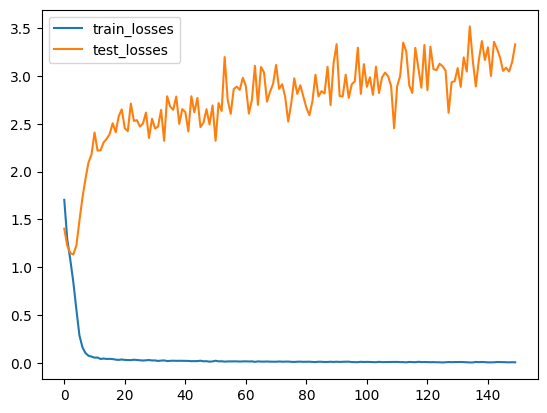

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

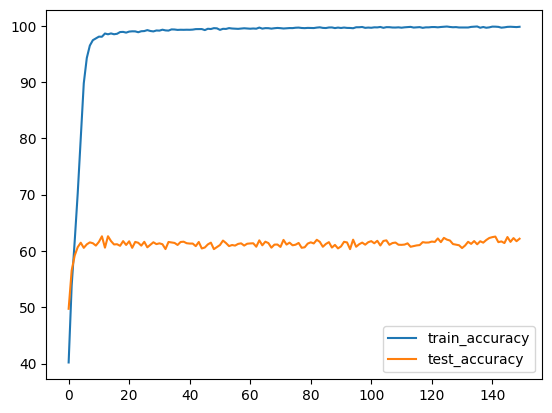

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()